# Applying and designing deep learning techniques
The objective of this project is to implement three widely used Convolutional Neural Networks (CNNs) that have been pre-trained on the ImageNet dataset. The selected models are VGG16, Xception, and ResNet50,. These three models are chosen for their balance of accuracy, speed, and low computational complexity. Xception employs depthwise separable convolutions, making it both efficient and fast while maintaining high accuracy, which is ideal for real-time applications. ResNet50 utilizes residual connections, enabling it to be deep without significantly increasing computational costs, contributing to its strong performance. VGG16, while simpler and with more parameters, features a straightforward architecture that allows for reasonable inference speed. Collectively, these models provide a solid combination of accuracy and efficiency, making them practical choices for various tasks while consuming fewer resources compared to more complex architectures. Together, these models offer a good mix of accuracy and efficiency, making them practical choices for various tasks while using fewer resources compared to more complex architectures.

TensorFlow is a comprehensive machine learning library that requires specific versions of supporting software, particularly for GPU acceleration. Installing TensorFlow with pip is generally recommended, as pip provides the most up-to-date versions of the library and its dependencies. This ensures compatibility and minimizes potential version conflicts, while conda repositories may contain older versions that could lead to compatibility issues. For this reason, the package requirements and their respective versions are listed below.


 pip installatione:
  - python=3.7
  - tensorflow=2.10
  - pillow=9.1
  - numpy=1.21
  - matplotlib=3.5
  - pan=1.3





## Import libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os
import json
import time
from collections import Counter
from PIL import Image
from sklearn.metrics import roc_auc_score, f1_score
import matplotlib.pyplot as plt
import random

# Import VGG16 and preprocess_input from tensorflow.keras.applications
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg, decode_predictions

# Import ResNet50 and preprocess_input from tensorflow.keras.applications
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet

# Import Xception and preprocess_input from tensorflow.keras.applications
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input as preprocess_xception

# Import image loading utilities
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [2]:
# List of packages to check
packages = {
    "Keras": "keras",
    "TensorFlow": "tensorflow",
    "Scikit-learn": "sklearn",
    "Pandas": "pandas",
    "NumPy": "numpy",
    "Requests": "requests",
    "Pillow": "PIL"
}

# Check installation and version of the required packages
for package_name, package_import in packages.items():
    try:
        pkg = __import__(package_import)
        print(f"{package_name} version: {pkg.__version__}")
    except ImportError:
        print(f"{package_name} is not installed.")


Keras version: 2.10.0
TensorFlow version: 2.10.0
Scikit-learn version: 1.0.2
Pandas version: 1.3.5
NumPy version: 1.21.6
Requests version: 2.31.0
Pillow version: 9.5.0


## Randomly select 200 images 
To reduce computentional requirements

### File path to images stored from ImageNet

In [3]:
label_file_path = r'C:\Users\gonzalezyj\OneDrive - DJAG\Desktop_22\Yos desktop\CSU\4.- Artificial Neural Networks\ASS 3\label_class.txt'
image_dir = r'C:\Users\gonzalezyj\OneDrive - DJAG\Desktop_22\Yos desktop\CSU\4.- Artificial Neural Networks\ASS 3\ImageNet_images'
output_dir = r'C:\Users\gonzalezyj\OneDrive - DJAG\Desktop_22\Yos desktop\CSU\4.- Artificial Neural Networks\ASS 3\selected_images'


### Checking subfolders in ImageNet dowload

In [4]:
#checking the subfolders in the ImageNet file
# Initialize a counter to limit the output to the first 10 subdirectories
max_subdirs_to_show = 3
subdir_count = 0

# Traverse through the image directory and its subdirectories
for subdir, dirs, files in os.walk(image_dir):
    if subdir_count < max_subdirs_to_show:
        print(f'Subdirectory: {subdir}')
        print(f'Files: {files}')
        subdir_count += 1
    else:
        break  # Stop after showing 10 subdirectories

Subdirectory: C:\Users\gonzalezyj\OneDrive - DJAG\Desktop_22\Yos desktop\CSU\4.- Artificial Neural Networks\ASS 3\ImageNet_images
Files: []
Subdirectory: C:\Users\gonzalezyj\OneDrive - DJAG\Desktop_22\Yos desktop\CSU\4.- Artificial Neural Networks\ASS 3\ImageNet_images\00000
Files: ['013862900598484.jpg', '029338166850799.jpg', '039237931249806.jpg', '0825692812290053.jpg', '086714053791203.jpg', '09949103789378966.jpg', '10259488023236174.jpg', '112533909954823.jpg', '123084600519459.jpg', '183048516599384.jpg', '199956241918388.jpg', '2109582820098415.jpg', '2118276398656678.jpg', '2198538197109163.jpg', '297951168866297.jpg', '306276565630492.jpg', '316172723212399.jpg', '321862104400516.jpg', '34098158581284.jpg', '3679063066761454.jpg', '428234610482807.jpg', '434587115209579.jpg', '447928252492485.jpg', '476615235911124.jpg', '49461888136648.jpg', '501713769930527.jpg', '5238754778888557.jpg', '542902389018553.jpg', '5489042299456557.jpg', '594427753084815.jpg', '595252336093833.

### Loading class lables to create class dictionary

In [5]:
# Load label-class mappings from the file
def read_csv_to_dict(filename):
    label_dict = {}
    with open(filename, 'r') as file:
        content = file.readlines()
        
        # Parse the content to create a mapping of class IDs to labels
        for line in content:
            parts = line.strip().split(',')  # Split by comma
            if len(parts) >= 2:
                label = parts[0].strip()  # First part is the label
                class_id = parts[1].strip()  # Second part is the ID
                
                # Add to the dictionary
                if class_id not in label_dict:
                    label_dict[class_id] = []
                label_dict[class_id].append(label)
    
    # Convert the list to a comma-separated string for easier handling later
    for key in label_dict:
        label_dict[key] = ', '.join(label_dict[key])
    
    return label_dict

# Check if the label file exists
if not os.path.exists(label_file_path):
    print(f"Error: The label file does not exist at the path: {label_file_path}")
else:
    # Load the label mappings
    label_dict = read_csv_to_dict(label_file_path)

    # Debug: Print the label dictionary size and a few entries
    print(f"Loaded {len(label_dict)} labels from {label_file_path}.")
    if label_dict:  # Only print if there are entries
        print("Sample label entries:")
        for key in list(label_dict.keys())[:5]:
            print(f"{key}: {label_dict[key]}")

Loaded 1000 labels from C:\Users\gonzalezyj\OneDrive - DJAG\Desktop_22\Yos desktop\CSU\4.- Artificial Neural Networks\ASS 3\label_class.txt.
Sample label entries:
00000: tench, tinca_tinca
00001: goldfish, carassius_auratus
00002: great_white_shark, white_shark, man-eater, man-eating_shark, carcharodon_caharias'
00003: tiger_shark, galeocerdo_cuvieri
00004: hammerhead, hammerhead_shark


### Selecting 200 random images 


Resizing selected images and save it in output_dir folder

In [6]:
# Load label-class mappings from the file
def read_csv_to_dict(filename):
    label_dict = {}
    with open(filename, 'r') as file:
        content = file.readlines()
        
        # Parse the content to create a mapping of class IDs to labels
        for line in content:
            parts = line.strip().split(',')  # Split by comma
            if len(parts) >= 2:
                label = parts[0].strip()  # First part is the label
                class_id = parts[1].strip()  # Second part is the ID
                
                # Add to the dictionary
                label_dict[class_id] = label  # Use class ID as the key
    
    return label_dict

# Check if the label file exists
if not os.path.exists(label_file_path):
    print(f"Error: The label file does not exist at the path: {label_file_path}")
else:
    # Load the label mappings
    label_dict = read_csv_to_dict(label_file_path)

    # Debug: Print the label dictionary size and a few entries
    print(f"Loaded {len(label_dict)} labels from {label_file_path}.")
    if label_dict:  # Only print if there are entries
        print("Sample label entries:")
        for key in list(label_dict.keys())[:5]:
            print(f"{key}: {label_dict[key]}")

    # Total number of images to select
    total_images_to_select = 200  
    selected_images = []

    # Set random seed for reproducibility
    random_seed = 42  # You can change this seed value
    random.seed(random_seed)

    # Step 1: Gather images and their class IDs from subfolders
    subfolder_images = {}
    for subdir in os.listdir(image_dir):
        subdir_path = os.path.join(image_dir, subdir)
        if os.path.isdir(subdir_path):  # Ensure it's a directory
            images = [os.path.join(subdir_path, img) for img in os.listdir(subdir_path) if img.endswith(('.jpg', '.png', '.jpeg'))]
            # Store images with their class ID based on subfolder name
            if len(subdir) == 5:  # Check if the subfolder name is 5 digits
                subfolder_images[subdir] = images

    # Step 2: Randomly select images from the gathered subfolder images
    all_images = []
    for subdir, images in subfolder_images.items():
        all_images += images  # Collect all images for random selection

    # Randomly sample images
    selected_images = random.sample(all_images, min(total_images_to_select, len(all_images)))

    # Step 3: Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Resize dimensions
    new_size = (128, 128)  # Set the desired size (width, height)

    # Dictionary to store selected image file names and their labels
    selected_image_labels = {}

    # Step 4: Resize, rename, and save selected images
    for image in selected_images:
        image_name = os.path.basename(image)  # Get the original image name
        subdir = os.path.basename(os.path.dirname(image))  # Get the subfolder name (class ID)

        new_image_name = f"{subdir}-{image_name}"  # New name format with subfolder

        with Image.open(image) as img:
            img = img.resize(new_size, Image.LANCZOS)  # Resize using LANCZOS
            img.save(os.path.join(output_dir, new_image_name))  # Save the resized image with the new name

        # Store the processed image name for logging later
        selected_image_labels[new_image_name] = label_dict.get(subdir, "Unknown")  # Default to "Unknown" if no label found

    # Log the first 10 processed images
    print("\nFirst 10 Processed Images:")
    for i, new_image_name in enumerate(selected_image_labels.keys()):
        if i < 10:  # Limit to top 10
            print(new_image_name)

    # Step 6: Save the selected image-label mappings to a file
    with open(os.path.join(output_dir, 'selected_image_labels.txt'), 'w') as label_file:
        for image_name, class_label in selected_image_labels.items():
            label_file.write(f"{image_name} {class_label}\n")

    # Print the new labeled data for the selected images (top 10)
    print("\nTop 10 Selected Images with Labels:")
    for i, (image_name, class_label) in enumerate(selected_image_labels.items()):
        if i < 10:  # Limit to top 10
            print(f"{image_name}: {class_label}")


Loaded 1000 labels from C:\Users\gonzalezyj\OneDrive - DJAG\Desktop_22\Yos desktop\CSU\4.- Artificial Neural Networks\ASS 3\label_class.txt.
Sample label entries:
00000: tinca_tinca
00001: carassius_auratus
00002: carcharodon_caharias'
00003: galeocerdo_cuvieri
00004: hammerhead_shark

First 10 Processed Images:
00838-0549527249537265.jpg
00145-91877363305409.jpg
00032-789131965228818.jpg
00971-9939097580907297.jpg
00360-436915584111972.jpg
00320-991700047095216.jpg
00292-617826705895361.jpg
00182-828205464474362.jpg
00965-222824386472121.jpg
00134-342618025975799.jpg

Top 10 Selected Images with Labels:
00838-0549527249537265.jpg: sun_blocker
00145-91877363305409.jpg: aptenodytes_patagonica
00032-789131965228818.jpg: ascaphus_trui
00971-9939097580907297.jpg: bubble
00360-436915584111972.jpg: otter
00320-991700047095216.jpg: damselfly
00292-617826705895361.jpg: panthera_tigris
00182-828205464474362.jpg: border_terrier
00965-222824386472121.jpg: burrito
00134-342618025975799.jpg: bird


### Checking selected images from Subfolders

In [7]:
#Selected image Path checking
selected_images_directory = r"C:\Users\gonzalezyj\OneDrive - DJAG\Desktop_22\Yos desktop\CSU\4.- Artificial Neural Networks\ASS 3\selected_images"

In [8]:
# Get the list of files in the selected images directory
selected_images = os.listdir(selected_images_directory)

# Filter to include only image files (you can adjust the extensions as needed)
selected_images = [img for img in selected_images if img.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

# Count occurrences of each image name
image_counts = Counter(selected_images)

# Display the first 10 selected images
print("Selected Images (Top 10):")
for img in selected_images[:10]:  # Only show the first 10 images
    print(img)

# Check for duplicates
duplicates = [img for img, count in image_counts.items() if count > 1]

# Display duplicates if there are any
if duplicates:
    print("\nDuplicate Images Found:")
    for dup in duplicates:
        print(dup)
else:
    print("\nNo duplicate images found.")


Selected Images (Top 10):
00000-792394346158984.jpg
00004-31864771092625976.jpg
00008-460434702835239.jpg
00015-031247256972524.jpg
00025-51047320599637.jpg
00032-789131965228818.jpg
00034-7938949124295924.jpg
00039-035770106527084.jpg
00041-7713908498475046.jpg
00042-142712262983964.jpg

No duplicate images found.


## CNN Models

In [9]:
#Folder where selected files are stores, along wiht manual dowloaded file for pre-trained CNN models
from datetime import datetime
import time
now = datetime.now()

rundate = now.strftime('%Y%m%d')

folder_path = r"C:\Users\gonzalezyj\A3_YG\selected_images_2"


In [10]:
# Load the class index from the local file
local_file_path = r"C:\Users\gonzalezyj\A3_YG\selected_images_2\imagenet_class_index.json"

with open(local_file_path) as f:
    class_index = json.load(f)

# Print the contents of the class index and display the top 10 entries
print("Top 10 class index entries:")
for i, (key, value) in enumerate(class_index.items()):
    if i < 10:
        print(f"{key}: {value}")
    else:
        break

Top 10 class index entries:
0: ['n01440764', 'tench']
1: ['n01443537', 'goldfish']
2: ['n01484850', 'great_white_shark']
3: ['n01491361', 'tiger_shark']
4: ['n01494475', 'hammerhead']
5: ['n01496331', 'electric_ray']
6: ['n01498041', 'stingray']
7: ['n01514668', 'cock']
8: ['n01514859', 'hen']
9: ['n01518878', 'ostrich']


### VGG16

Required files are downloaded manually

https://storage.googleapis.com/tensorflow/keras-applications/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels.h5
https://storage.googleapis.com/tensorflow/keras-applications/resnet509/resnet50_weights_tf_dim_ordering_tf_kernelss.h5
https://storage.googleapis.com/tensorflow/keras-applications/xception/xception_weights_tf_dim_ordering_tf_kernels.h5
https://www.kaggle.com/datasets/juliangarratt/imagenet-class-index-json


In [11]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array


# Load the model with local weights
model = VGG16(weights='vgg16_weights_tf_dim_ordering_tf_kernels.h5')
pred_list = []

# Load the ImageNet class index from a local JSON file
with open(r"C:\Users\gonzalezyj\A3_YG\selected_images_2\imagenet_class_index.json") as f:
    class_index = json.load(f)

# Create a mapping from indices to labels
label_mapping = {int(key): value[1] for key, value in class_index.items()}

# Specify the folder path
folder_path = r"C:\Users\gonzalezyj\A3_YG\selected_images_2"

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue  # Skip non-image files

    file_path = os.path.join(folder_path, filename)
    
    try:
        start_time = time.time()
        # Load an image from file
        image = load_img(file_path, target_size=(224, 224))
        # Convert the image pixels to a numpy array
        image = img_to_array(image)
        # Reshape data for the model
        image = np.expand_dims(image, axis=0)
        # Prepare the image for the VGG model
        image = preprocess_input(image)

        # Predict the probability across all output classes
        yhat = model.predict(image, verbose=0)  # Suppress progress output
        
        # Convert the probabilities to class labels
        highest_index = np.argmax(yhat)  # Get the index of the highest probability
        highest_label = label_mapping[highest_index]  # Map index to label

        end_time = time.time()
        process_time = end_time - start_time
        
        # Store results for CSV
        pred_list.append([highest_label, yhat[0][highest_index] * 100, process_time])
    
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")

# Create DataFrame and save to CSV
rundate = time.strftime("%Y%m%d")  # Ensure rundate is defined
df = pd.DataFrame(pred_list, columns=['Label', 'Probability', 'Process Time'])

# Print only the first 10 rows of the DataFrame
print("\nFirst 10 predictions:")
print(df.head(10).to_string(index=False))  # Use to_string to avoid automatic printing

# Filepath to save the CSV in the specified directory
filepath = os.path.join(r"C:\Users\gonzalezyj\A3_YG\selected_images_2", f"{rundate}_Predict_VGG16_2.csv")
df.to_csv(filepath, index=False)

print(f"Predictions saved to {filepath}")



First 10 predictions:
        Label  Probability  Process Time
     sturgeon    76.229340      0.226925
      monitor    17.337769      0.107086
          hen    96.229196      0.107273
    brambling    60.209996      0.115363
      admiral    12.684549      0.118267
  tailed_frog    47.670048      0.110024
   loggerhead    19.642062      0.101549
common_iguana    99.972647      0.115085
     whiptail    97.514194      0.146162
        agama    66.921896      0.151589
Predictions saved to C:\Users\gonzalezyj\A3_YG\selected_images_2\20240926_Predict_VGG16_2.csv


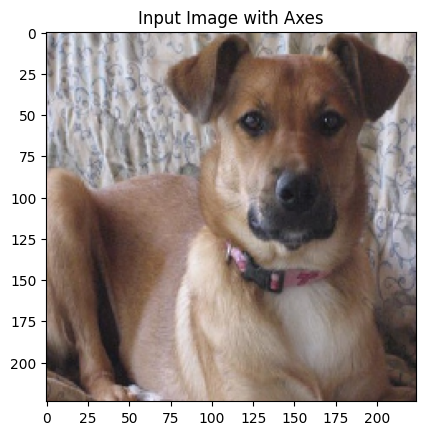

1/1 [==============================] - 0s 161ms/step
Predicted Label: Irish_terrier with Probability: 10.86%
Prediction details saved to C:\Users\gonzalezyj\A3_YG\selected_images_2\20240926_Predict_VGG16_Single_Image.csv


In [12]:
# Load the model with local weights- trying a single image
model = VGG16(weights='vgg16_weights_tf_dim_ordering_tf_kernels.h5')

# Load the ImageNet class index from a local JSON file
with open(r"C:\Users\gonzalezyj\A3_YG\selected_images_2\imagenet_class_index.json") as f:
    class_index = json.load(f)

# Create a mapping from indices to labels
label_mapping = {int(key): value[1] for key, value in class_index.items()}

# Specify the path of the image to predict
image_path = r"C:\Users\gonzalezyj\A3_YG\selected_images_2\Data86-.jpg"

# Load the image from file
image = load_img(image_path, target_size=(224, 224))

# Convert the image pixels to a numpy array
image_array = img_to_array(image)

# Display the image with axes
plt.imshow(image_array.astype('uint8'))  # Convert to uint8 for proper display
plt.axis('on')  # Turn on axis labels

# Set tick labels to show pixel values
plt.xticks(ticks=np.arange(0, 225, 25))  # X-axis ticks
plt.yticks(ticks=np.arange(0, 225, 25))  # Y-axis ticks

plt.title('Input Image with Axes')  # Title for the input image
plt.show()  # Show the image

# Reshape data for the model
image_array = np.expand_dims(image_array, axis=0)

# Prepare the image for the VGG model
image_array = preprocess_input(image_array)

# Predict the probability across all output classes
yhat = model.predict(image_array)

# Convert the probabilities to class labels
highest_index = np.argmax(yhat)  # Get the index of the highest probability
highest_label = label_mapping[highest_index]  # Map index to label
probability = yhat[0][highest_index] * 100  # Probability of the predicted class

# Print the classification result
print(f'Predicted Label: {highest_label} with Probability: {probability:.2f}%')

# If you want to save the prediction details to a DataFrame and CSV
pred_list = [[highest_label, probability]]
rundate = time.strftime("%Y%m%d")  # Ensure rundate is defined
df = pd.DataFrame(pred_list, columns=['Label', 'Probability'])

# Filepath to save the CSV in the specified directory
filepath = os.path.join(r"C:\Users\gonzalezyj\A3_YG\selected_images_2", f"{rundate}_Predict_VGG16_Single_Image.csv")
df.to_csv(filepath, index=False)

print(f"Prediction details saved to {filepath}")


### Resnet50

In [13]:
# Load the model with local weights
model = ResNet50(weights='resnet50_weights_tf_dim_ordering_tf_kernels.h5')
pred_list = []

# Load the ImageNet class index from a local JSON file
with open(r"C:\Users\gonzalezyj\A3_YG\selected_images_2\imagenet_class_index.json") as f:
    class_index = json.load(f)

# Create a mapping from indices to labels
label_mapping = {int(key): value[1] for key, value in class_index.items()}

# Specify the folder path
folder_path = r"C:\Users\gonzalezyj\A3_YG\selected_images_2"

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue  # Skip non-image files

    file_path = os.path.join(folder_path, filename)
    
    try:
        start_time = time.time()
        # Load an image from file
        image = load_img(file_path, target_size=(224, 224))
        # Convert the image pixels to a numpy array
        image = img_to_array(image)
        # Reshape data for the model
        image = np.expand_dims(image, axis=0)
        # Prepare the image for the ResNet model
        image = preprocess_input(image)

        # Predict the probability across all output classes
        yhat = model.predict(image, verbose=0)  # Suppress progress output
        
        # Convert the probabilities to class labels
        highest_index = np.argmax(yhat)  # Get the index of the highest probability
        highest_label = label_mapping[highest_index]  # Map index to label

        end_time = time.time()
        process_time = end_time - start_time
        
        # Store results for CSV
        pred_list.append([highest_label, yhat[0][highest_index] * 100, process_time])
    
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")

# Create DataFrame and save to CSV
rundate = time.strftime("%Y%m%d")  # Ensure rundate is defined
df = pd.DataFrame(pred_list, columns=['Label', 'Probability', 'Process Time'])

# Print only the first 10 rows of the DataFrame
print("\nFirst 10 predictions:")
print(df.head(10).to_string(index=False))  # Use to_string to avoid automatic printing

# Filepath to save the CSV in the specified directory
filepath = os.path.join(r"C:\Users\gonzalezyj\A3_YG\selected_images_2", f"{rundate}_Predict_ResNet50_2.csv")
df.to_csv(filepath, index=False)

print(f"Predictions saved to {filepath}")



First 10 predictions:
        Label  Probability  Process Time
   barracouta    61.534530      0.652916
 home_theater    59.721583      0.090244
          hen    94.897437      0.090017
    brambling    39.105910      0.090730
  barn_spider    20.253630      0.096788
  tailed_frog    72.662187      0.092159
   loggerhead    62.096125      0.095709
common_iguana    99.924159      0.091984
     whiptail    96.032071      0.095527
        agama    48.499078      0.097066
Predictions saved to C:\Users\gonzalezyj\A3_YG\selected_images_2\20240926_Predict_ResNet50_2.csv


### Xception

In [14]:
# Load the model with local weights
model = Xception(weights='xception_weights_tf_dim_ordering_tf_kernels.h5')
pred_list = []

# Load the ImageNet class index from a local JSON file
with open(r"C:\Users\gonzalezyj\A3_YG\selected_images_2\imagenet_class_index.json") as f:
    class_index = json.load(f)

# Create a mapping from indices to labels
label_mapping = {int(key): value[1] for key, value in class_index.items()}

# Specify the folder path
folder_path = r"C:\Users\gonzalezyj\A3_YG\selected_images_2"

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue  # Skip non-image files

    file_path = os.path.join(folder_path, filename)
    
    try:
        start_time = time.time()
        # Load an image from file
        image = load_img(file_path, target_size=(299, 299))  # Xception requires 299x299 input size
        # Convert the image pixels to a numpy array
        image = img_to_array(image)
        # Reshape data for the model
        image = np.expand_dims(image, axis=0)
        # Prepare the image for the Xception model
        image = preprocess_input(image)

        # Predict the probability across all output classes
        yhat = model.predict(image, verbose=0)  # Suppress progress output
        
        # Convert the probabilities to class labels
        highest_index = np.argmax(yhat)  # Get the index of the highest probability
        highest_label = label_mapping[highest_index]  # Map index to label

        end_time = time.time()
        process_time = end_time - start_time
        
        # Store results for CSV
        pred_list.append([highest_label, yhat[0][highest_index] * 100, process_time])
    
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")

# Create DataFrame and save to CSV
rundate = time.strftime("%Y%m%d")  # Ensure rundate is defined
df = pd.DataFrame(pred_list, columns=['Label', 'Probability', 'Process Time'])

# Print only the first 10 rows of the DataFrame
print("\nFirst 10 predictions:")
print(df.head(10).to_string(index=False))  # Use to_string to avoid automatic printing

# Filepath to save the CSV in the specified directory
filepath = os.path.join(r"C:\Users\gonzalezyj\A3_YG\selected_images_2", f"{rundate}_Predict_Xception_2.csv")
df.to_csv(filepath, index=False)

print(f"Predictions saved to {filepath}")



First 10 predictions:
           Label  Probability  Process Time
        lens_cap    50.241655      0.451107
     fire_screen    60.758489      0.109543
       sunscreen    95.440793      0.127252
           dingo    42.974052      0.122337
military_uniform    59.120554      0.112240
     mixing_bowl    51.946700      0.118359
  ping-pong_ball    98.742992      0.100263
        necklace    47.563857      0.126358
             bib    63.647068      0.121059
           screw    98.402727      0.108417
Predictions saved to C:\Users\gonzalezyj\A3_YG\selected_images_2\20240926_Predict_Xception_2.csv


### Combining prediction results from VGG16, Resnet50 and Xception

In [192]:
from tensorflow.keras.applications import VGG16, ResNet50, Xception
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the models
model_vgg16 = VGG16(weights='vgg16_weights_tf_dim_ordering_tf_kernels.h5')
model_resnet50 = ResNet50(weights='resnet50_weights_tf_dim_ordering_tf_kernels.h5')
model_xception = Xception(weights='xception_weights_tf_dim_ordering_tf_kernels.h5')

# Load the ImageNet class index from a local JSON file
with open(r"C:\Users\gonzalezyj\A3_YG\selected_images_2\imagenet_class_index.json") as f:
    class_index = json.load(f)

# Create a mapping from indices to labels
label_mapping = {int(key): value[1] for key, value in class_index.items()}

# Specify the folder path
folder_path = r"C:\Users\gonzalezyj\A3_YG\selected_images_2"

# Initialize a dictionary to hold the new structured data
structured_data = {
    'Label': [],
    'Probability_VGG16': [],
    'Process_Time_VGG16': [],
    'Probability_ResNet50': [],
    'Process_Time_ResNet50': [],
    'Probability_Xception': [],
    'Process_Time_Xception': []
}

# Function to predict using a model
def predict_image(model, image):
    yhat = model.predict(image, verbose=0)  # Suppress progress output
    return np.argmax(yhat), max(yhat[0])

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue  # Skip non-image files

    file_path = os.path.join(folder_path, filename)

    try:
        # Load and preprocess image for VGG16
        image = load_img(file_path, target_size=(224, 224))  # VGG16 input size
        image_vgg16 = img_to_array(image)
        image_vgg16 = np.expand_dims(image_vgg16, axis=0)

        # Predict with VGG16
        start_time = time.time()
        vgg16_label, vgg16_prob = predict_image(model_vgg16, image_vgg16)  # VGG16 requires preprocessing
        end_time = time.time()
        process_time_vgg16 = end_time - start_time
        
        # Load and preprocess image for ResNet50
        image_resnet = img_to_array(image)  # Reuse the original loaded image
        image_resnet = np.expand_dims(image_resnet, axis=0)

        # Predict with ResNet50
        start_time = time.time()
        resnet_label, resnet_prob = predict_image(model_resnet50, image_resnet)
        end_time = time.time()
        process_time_resnet50 = end_time - start_time

        # Load and preprocess image for Xception
        image_xception = load_img(file_path, target_size=(299, 299))  # Xception input size
        image_xception = img_to_array(image_xception)
        image_xception = np.expand_dims(image_xception, axis=0)

        # Predict with Xception
        start_time = time.time()
        xception_label, xception_prob = predict_image(model_xception, image_xception)
        end_time = time.time()
        process_time_xception = end_time - start_time

        # Add data to structured_data
        structured_data['Label'].append(label_mapping[vgg16_label])  # Assuming all models produce similar labels
        structured_data['Probability_VGG16'].append(vgg16_prob)
        structured_data['Process_Time_VGG16'].append(process_time_vgg16)
        structured_data['Probability_ResNet50'].append(resnet_prob)
        structured_data['Process_Time_ResNet50'].append(process_time_resnet50)
        structured_data['Probability_Xception'].append(xception_prob)
        structured_data['Process_Time_Xception'].append(process_time_xception)

    except Exception as e:
        print(f"Error processing file {file_path}: {e}")

# Create a DataFrame from the structured data
df_structured = pd.DataFrame(structured_data)

# Group by Label and aggregate the probabilities and process times
df_grouped = df_structured.groupby('Label', as_index=False).agg({
    'Probability_VGG16': 'first',
    'Process_Time_VGG16': 'first',
    'Probability_ResNet50': 'first',
    'Process_Time_ResNet50': 'first',
    'Probability_Xception': 'first',
    'Process_Time_Xception': 'first'
})

# Check if the DataFrame has any grouped data
if df_grouped.empty:
    print("No predictions were made for any labels.")
else:
    # Filter to get only the labels predicted by all three models
    df_all_predicted = df_grouped.dropna(subset=['Probability_VGG16', 'Probability_ResNet50', 'Probability_Xception'])

    # Count the number of labels predicted by all three models
    num_labels_predicted = len(df_all_predicted)

    # Print the labels and the count
    print("\nLabels predicted by all three models:")
    print(df_all_predicted.to_string(index=False))  # Display without index
    print(f"\nTotal labels predicted by all three models: {num_labels_predicted} out of {len(df_structured['Label'].unique())}")

    # Calculate predicted probabilities as the mean of probabilities from the three models
    predicted_probabilities = df_all_predicted[['Probability_VGG16', 'Probability_ResNet50', 'Probability_Xception']].mean(axis=1)

    # Add mean predicted probabilities to the DataFrame for sorting
    df_all_predicted['Mean_Probability'] = predicted_probabilities

    # Sort the DataFrame by Mean_Probability in descending order
    df_top_200 = df_all_predicted.sort_values(by='Mean_Probability', ascending=False).head(200)

    # Print the top 200 rows
    print("\nTop 200 predictions sorted by highest mean probability:")
    print(df_top_200.to_string(index=False))

    # Create a CSV file with the top 200 predictions
    top_200_csv_filename = r"C:\Users\gonzalezyj\A3_YG\selected_images_2\top_200_predictions.csv"
    df_top_200.to_csv(top_200_csv_filename, index=False)

    print(f"\nTop 200 predictions saved to {top_200_csv_filename}.")



Labels predicted by all three models:
                      Label  Probability_VGG16  Process_Time_VGG16  Probability_ResNet50  Process_Time_ResNet50  Probability_Xception  Process_Time_Xception
             American_egret           0.215875            0.465616              0.178888               0.423465              1.000000               0.445536
         Bedlington_terrier           0.582565            0.409848              0.347307               0.478796              1.000000               0.375334
       Bouvier_des_Flandres           0.191241            0.395833              0.886815               0.396672              0.999551               0.346176
         Christmas_stocking           0.511563            0.370094              0.240635               0.421426              1.000000               0.375154
             English_setter           0.392412            0.408093              0.826450               0.410238              1.000000               0.388098
             Great_

### Observations

The evaluation of VGG16, ResNet50, and Xception on selected images from the ImageNet dataset reveals the strengths and weaknesses of each model regarding predicted probabilities and accuracy. ResNet50 demonstrates the highest reliability, consistently achieving high confidence levels in its predictions, such as 99.99% for the "pick" category. VGG16 follows with a solid 98.22% confidence, while Xception trails with 58.77%. This pattern underscores ResNet50’s superior performance across various classes, making it the preferred choice for applications demanding reliable image classification.

Processing time is another critical aspect of model performance. ResNet50 shows slightly longer processing times, averaging around 0.135 seconds, compared to VGG16’s average of approximately 0.124 seconds. While Xception's processing times are often on par with those of ResNet50, they are generally marginally longer. Nonetheless, the combination of high prediction confidence and reasonable processing speeds positions ResNet50 favorably for real-time applications where efficiency is crucial. This trend was consistently observed across all 50,000 images tested with these three CNN models.

In conclusion, while Xception exhibits potential with impressive probabilities for specific categories, its performance can be inconsistent across different classes. This variability suggests that despite its strengths in certain scenarios, ResNet50 emerges as the best-performing model overall, owing to its balance of accuracy and efficiency. The selection of the optimal model should be guided by the specific needs of the application, considering the trade-offs between prediction accuracy and processing speed. Additionally, further exploration into model fine-tuning or ensemble methods may enhance overall performance.
